There are 28575 possible states
4.0951,16
4.0951,219
4.68559,386
4.217031,518
3.7953279000000006,635
3.415795110000001,712
3.3170310000000005,794
2.9853279000000006,836
2.686795110000001,839
2.418115599000001,795
2.1359326833270087,774
1.9223394149943074,737
1.4803767351900008,644
1.332339061671001,747
1.8966854649908267,807
2.7052724263816526,526
2.4347451837434875,590
3.4504456127343084,668
3.1054010514608774,727
2.7948609463147895,771
2.5153748516833105,796
2.2638373665149794,818
2.0374536298634816,821
1.1645310736744405,779
1.0480779663069963,791
0.9432701696762967,769
0.8489431527086672,696
0.7640488374378005,725
0.6876439536940204,673
0.43789163574355094,590
1.8990870241833488,654
1.7091783217650138,723
1.5382604895885126,785
1.3844344406296614,835
1.2459909965666953,879
1.1213918969100256,914
0.5314409999999998,940
0.02031515269981099,955
0.018283637429829892,961
0.0164552736868469,927
0.01480974631816221,877
0.01332877168634599,810
0.011995894517711393,808
0.006082667877133584,

MovieWriter ffmpeg unavailable; using Pillow instead.


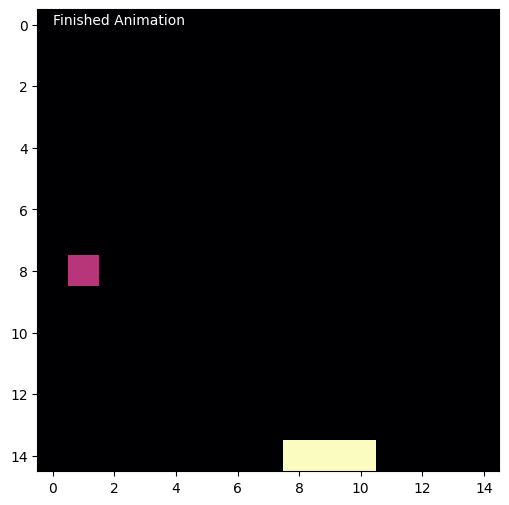

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class Game:
    def __init__(self, N, paddle_width, vel_max=1):
        self.N = N
        self.paddle_width = paddle_width
        self.vel_max = vel_max
        self.reset_game()
        
        self.policy = {}
        self.values = {}
        # For each ball position
        pix = np.arange(N)
        X, Y = np.meshgrid(pix, pix)
        for x, y in zip(X.flatten(), Y.flatten()):
            # For each ball velocity
            pix = np.arange(-vel_max, vel_max+1)
            VX, VY = np.meshgrid(pix, pix)
            VX = VX.flatten()
            VY = VY.flatten()
            if y == N-1:
                # At the bottom; ball stops
                VX, VY = [0], [0]
            for vx, vy in zip(VX, VY):
                # For each paddle position
                for paddle_x in np.arange(N):
                    # Pick a random action
                    choices = [0]
                    if paddle_x > 0:
                        choices.append(-1)
                    if paddle_x < N-1:
                        choices.append(1)
                    self.policy[(x, y, vx, vy, paddle_x)] = np.random.choice(choices)
                    self.values[(x, y, vx, vy, paddle_x)] = 0
                    
    def reset_game(self):
        self.ball_pos = [np.random.randint(self.N), 0] #x, y
        self.ball_vel = [np.random.randint(-self.vel_max, self.vel_max+1), np.random.randint(1, self.vel_max+1)]
        self.paddle_x = np.random.randint(self.N)
    
    def get_state(self):
        return (self.ball_pos[0], self.ball_pos[1], self.ball_vel[0], self.ball_vel[1], self.paddle_x)
    
    def get_value(self):
        ret = 0
        if self.ball_pos[1] == self.N-1:
            ret = -1
        return ret
    
    def render(self):
        grid = np.zeros((self.N, self.N))
        grid[self.ball_pos[1], self.ball_pos[0]] = 1
        xmin = max(self.paddle_x-self.paddle_width//2, 0)
        xmax = min(self.paddle_x+self.paddle_width//2, self.N-1)
        grid[-1, xmin:xmax+1] = 2
        return plt.imshow(grid, cmap='magma')
    
    def game_over(self):
        x = self.paddle_x
        dx = self.paddle_width//2
        return self.ball_pos[1] == self.N-1 and (self.ball_pos[0] < x-dx or self.ball_pos[0] > x+dx)
    
    def step(self):
        self.paddle_x += self.policy[self.get_state()]
        just_bounced = False
        for k in range(2):
            # Move and bounce off of walls if necessary
            self.ball_pos[k] += self.ball_vel[k]
        if self.ball_pos[0] < 0:
            self.ball_pos[0] = 0
            self.ball_vel[0] *= -1
        elif self.ball_pos[0] > self.N-1:
            self.ball_pos[0] = self.N-1
            self.ball_vel[0] *= -1
        if self.ball_pos[1] < 0:
            self.ball_pos[1] = 0
            self.ball_vel[1] *= -1
        elif self.ball_pos[1] > self.N-2:
            # Check to see if x positions is within paddle width
            x = self.paddle_x
            dx = self.paddle_width//2
            if self.ball_pos[0] >= x-dx and self.ball_pos[0] <= x+dx:
                just_bounced = True
                self.ball_pos[1] = self.N-2
                # Make a random velocity going up
                self.ball_vel[0] = np.random.randint(-self.vel_max, self.vel_max+1)
                self.ball_vel[1] = np.random.randint(-self.vel_max, 0)
            else:
                self.ball_vel[0] = 0
                self.ball_vel[1] = 0
                self.ball_pos[1] = self.N-1
        return just_bounced
    
    def play_game(self, max_steps=300):
        i = 0
        fig = plt.figure(figsize=(6, 6))
        frames = []
        while i < max_steps and not self.game_over():
            s = "Frame {}, Ball ({}, {}) @ ({}, {}), Paddle {}".format(i, self.ball_pos[0], self.ball_pos[1], 
                                                                       self.ball_vel[0], self.ball_vel[1], 
                                                                       self.paddle_x)
            frames.append([self.render(), plt.text(0, 0, s, c='white')])
            self.step()
            i += 1
        # Draw 10 more frames to show the game being over
        for k in range(10):
            frames.append([self.render(), plt.text(0, 0, "Finished Animation", c='white')])
        
        ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat_delay=1000)
        ani.save("game.gif")
    
    def policy_evaluation(self, gamma, iters):
        # https://gibberblot.github.io/rl-notes/single-agent/policy-iteration.html
        max_change = 0
        for i in range(iters):
            for key in self.policy: # Go through every possible state
                (x, y, vx, vy, paddle_x) = key
                self.ball_pos = [x, y]
                self.ball_vel = [vx, vy]
                self.paddle_x = paddle_x
                just_bounced = self.step()
                key2 = [self.ball_pos[0], self.ball_pos[1], self.ball_vel[0], self.ball_vel[1], self.paddle_x]
                # Ordinary Case
                value = gamma*self.values[tuple(key2)]
                if self.game_over():
                    value -= 1
                # Bounce Case
                if just_bounced:
                    value = 0
                    for vel in range(-self.vel_max, self.vel_max+1):
                        key2[2] = vel
                        value += (gamma/(2*self.vel_max+1))*self.values[tuple(key2)]
                dvalue = abs(value - self.values[key])
                max_change = max(max_change, dvalue)
                self.values[key] = value
        return max_change
    
    
    def policy_iteration(self, gamma):
        num_changed = 0
        for key in self.policy:
            (x, y, vx, vy, orig_paddle_x) = key
            self.ball_pos = [x, y]
            self.ball_vel = [vx, vy]
            self.paddle_x = orig_paddle_x
            just_bounced = self.step()
            key2 = [self.ball_pos[0], self.ball_pos[1], self.ball_vel[0], self.ball_vel[1], orig_paddle_x]
            # Try all actions
            changed = False
            for dx in [-1, 0, 1]:
                paddle_x = orig_paddle_x + dx
                if paddle_x < 0:
                    continue
                if paddle_x >= self.N:
                    continue
                key2[-1] = paddle_x

                # Ordinary Case
                value = gamma*self.values[tuple(key2)]
                if self.game_over():
                    value -= 1
                # Bounce Case
                if just_bounced:
                    value = 0
                    for vel in range(-self.vel_max, self.vel_max+1):
                        key2[2] = vel
                        value += (gamma/(2*self.vel_max+1))*self.values[tuple(key2)]
                if value > self.values[key]:
                    self.policy[key] = dx
                    changed = True
            if changed:
                num_changed += 1
        return num_changed
            
            
        

pong = Game(15, 3, 1)
print("There are {} possible states".format(len(pong.policy)))

gamma = 0.9
for i in range(50):
    print(pong.policy_evaluation(gamma, 1), end=",")
    print(pong.policy_iteration(gamma))
    
pong.reset_game()
pong.play_game(400)